# IRDAI Public Disclosures

In accordance with regulations stipulated by the Insurance Regulatory and Development Authority of India (IRDAI), Insurance Companies are [required](https://irdai.gov.in/documents/37343/1082836/Public+Disclosures+by+Insurers%2C+Jan+2010+Attachment-1.pdf/9d7906ac-361f-2f59-7e45-ad94423eea57?version=2.0&t=1640594619617) to publish data on their Revenue Account, Profit & Loss Account, Balance Sheet, schedules to accounts, and other forms. This represents a rich archive of high-frequency (quarterly) publicly-available data on the insurance sector in India.

In this notebook, I provide an efficient, reproducible process for scraping and running lookups on this data.

## Requirements

In [190]:
import re, requests, os, heapq
import pandas as pd
import camelot as cm
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
# Directory?

## Reading the PDF

I use the latest document (at the time of writing) from ICICI PruLife and save it in my working directory for `Camelot` to read.

In [18]:
pdf_url = "https://www.iciciprulife.com/content/dam/icicipru/about-us/PublicDisclosures/FY2024/fy2024q1c/FY_2024_Q1_Consolidated.pdf"
fname = 'ins_doc.pdf'

In [19]:
with open(fname, 'wb') as f: 
    f.write(requests.get(pdf_url).content)

Using Camelot, I extract embedded tables from the PDF while validating process accuracy.

In [56]:
tabs = cm.read_pdf(fname, pages='3-5', stream='False')

However, the multi-cell layout on most documents is misread by `Camelot`, resulting in whitespace and newline characters being injected into cells, such as below.

In [58]:
tabs[0].df.loc[3,4]

'1,158\n           \n(1,320)\n                \n-\n            \n1,048\n            \n1,631\n              \n(402)\n            \n8,253\n                  \n66\n                \n-\n                \n-\n                \n-\n                \n-\n                \n-'

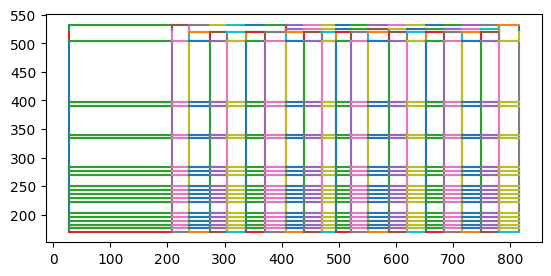

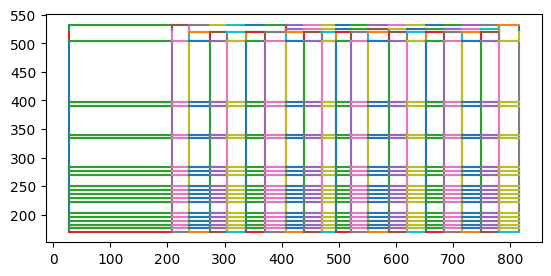

In [65]:
cm.plot(tabs[0], kind='grid')

The vanilla `Camelot` parser naively follows demarcated PDF table borders and merges string data in the same cell using `PDFMiner`. 

Therefore, I reconfigure the `Camelot` parse process to split strings that have been merged together, which narrows textedges and links text horizontally.

In [66]:
tabs = cm.read_pdf(fname, pages='3-5', flavor='stream', split_text=True)

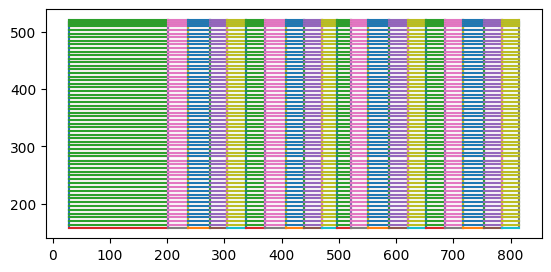

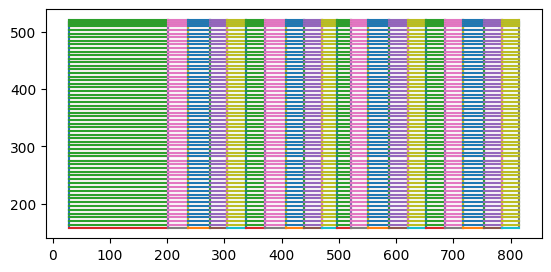

In [44]:
cm.plot(tabs[0], kind='grid')

I validate the text accuracy at the end of this approach.

In [43]:
sum([x.parsing_report['accuracy'] for x in tabs]) / len(tabs)

95.14

## Data Cleaning

Let's take a look at the extracted tables.

In [45]:
df = tabs[0].df

In [109]:
df.head(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Particulars,Ref. Form,,,,,,,,,,,,,,,,,,Grand Total
1,,,,,,Variable,,,,,,Variable,,,,,,Variable,,
2,,No.,Life,Pension,Health,,Total,Life,Annuity,Pension,Health,,Total,Life,Annuity,Pension,Health,,Total,
3,,,,,,Insurance,,,,,,Insurance,,,,,,Insurance,,
4,Premiums earned – net,,,,,,,,,,,,,,,,,,,
5,(a) Premium,L-4,"326,343","13,278","1,158",NaN,"340,779","80,419",NaN,164,NaN,NaN,"80,583","253,595","42,482","17,605",883,"1,549","316,114","737,476"


Clearly, this requires significant data cleaning. I begin by imputing empty values.

In [83]:
df.replace('-', np.nan, inplace=True)
df.replace(',', '', inplace=True)

I then devise a method of algorithmically ascertaining the header and the first data row.

In [140]:
nrows = 7
toprows = range(nrows+1)

In [193]:
len([x for x in df.loc[1,:] if x==''])

17

In [241]:
row = 0
while row<nrows+1:
    factor = len(df.columns) * 0.50
    if len([x for x in df.loc[row,:] if x=='']) < factor:
        head_n = row
        break
    else:
        row+=1

blanks = {}


In [242]:
head_n

2

In [118]:
lenrows = {len(df.loc[row,:].sum()):row for row in toprows}

TypeError: can only concatenate str (not "int") to str

In [ ]:
len

In [115]:
list(lenrows.keys()).sort()

In [111]:
lenrows.get(max(lenrows.keys()))

2

In [91]:
df.drop([0,1], axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,,,,,,,,,,,,,,,,,,Grand Total
1,,,,Variable,,,,,,Variable,,,,,,Variable,,
2,Life,Pension,Health,,Total,Life,Annuity,Pension,Health,,Total,Life,Annuity,Pension,Health,,Total,
3,,,,Insurance,,,,,,Insurance,,,,,,Insurance,,
4,,,,,,,,,,,,,,,,,,
5,"326,343","13,278","1,158",NaN,"340,779","80,419",NaN,164,NaN,NaN,"80,583","253,595","42,482","17,605",883,"1,549","316,114","737,476"
6,(559),NaN,"(1,320)",NaN,"(1,879)",(203),NaN,NaN,NaN,NaN,(203),"(33,150)",NaN,NaN,(241),NaN,"(33,391)","(35,473)"
7,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN
8,,,,,,,,,,,,,,,,,,
9,"96,892","10,641","1,048",NaN,"108,581","44,432",NaN,"2,803",NaN,NaN,"47,235","79,074","20,813","2,322",135,300,"102,644","258,460"


In [70]:
df.transpose().dtypes

0     object
1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
11    object
12    object
13    object
14    object
15    object
16    object
17    object
18    object
19    object
20    object
21    object
22    object
23    object
24    object
25    object
26    object
27    object
28    object
29    object
30    object
31    object
32    object
33    object
34    object
35    object
36    object
37    object
38    object
39    object
40    object
41    object
42    object
43    object
44    object
45    object
46    object
47    object
48    object
49    object
50    object
51    object
52    object
53    object
54    object
55    object
56    object
57    object
dtype: object